# PubMed Abstract Crawler and Analyzer
Cited as Requested: 

Comeau DC, Wei CH, Islamaj Doğan R, and Lu Z. PMC text mining subset in BioC: about 3 million full text articles and growing, Bioinformatics, btz070, 2019

In [74]:
import requests
import pandas as pd
import numpy as np
import re
import time

## Web Crawling PubMed Searches and Extracting the Abstracts

In [23]:
BASE_URL = 'https://pubmed.ncbi.nlm.nih.gov'
SAMPLE_SEARCH_TERM = 'Smita S Patel'

url = BASE_URL + '/?term=' + SAMPLE_SEARCH_TERM.strip().replace(' ', '+')
url

'https://pubmed.ncbi.nlm.nih.gov/?term=Smita+S+Patel'

In [12]:
page = requests.get(url=url)
page

<Response [200]>

In [13]:
from bs4 import BeautifulSoup

In [17]:
soup = BeautifulSoup(page.content, 'html.parser')
documents = soup.findAll(class_= 'docsum-title')
print(documents[0])


<a class="docsum-title" data-article-id="33127643" data-full-article-url="from_term=Smita+S+Patel&amp;from_pos=1" data-ga-action="1" data-ga-category="result_click" data-ga-label="33127643" href="/33127643/" ref="linksrc=docsum_link&amp;article_id=33127643&amp;ordinalpos=1&amp;page=1">
              
                Structure, mechanism, and regulation of mitochondrial DNA transcription initiation.
              
            </a>


In [19]:
documents[0].contents[0].strip()

'Structure, mechanism, and regulation of mitochondrial DNA transcription initiation.'

In [24]:
BASE_URL + documents[0].get('href')

'https://pubmed.ncbi.nlm.nih.gov/33127643/'

In [26]:
documents[0].get('data-article-id')

'33127643'

### Creating a Loop for a Single Page

In [27]:
df = pd.DataFrame(columns= ['ArticleID', 'ArticleName', 'URL'])
for document in documents:
    article_id = document.get('data-article-id')
    article_name = document.contents[0].strip()
    article_url = BASE_URL + document.get('href')

    df.loc[len(df.index)] = [article_id, article_name, article_url]
df.head()

,ArticleID,ArticleName,URL
0,33127643,"Structure, mechanism, and regulation of mitoch...",https://pubmed.ncbi.nlm.nih.gov/33127643/
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/
2,16670085,Mechanisms of helicases.,https://pubmed.ncbi.nlm.nih.gov/16670085/
3,16935879,Mechanisms of a ring shaped helicase.,https://pubmed.ncbi.nlm.nih.gov/16935879/
4,30707952,Time-resolved analysis of transcription throug...,https://pubmed.ncbi.nlm.nih.gov/30707952/


In [29]:
article_page = requests.get(url= df.loc[0]['URL'])
article_page

<Response [200]>

In [60]:
article_soup = BeautifulSoup(article_page.content, 'html.parser')

authors_list_items = article_soup.findAll(class_='authors-list-item')
authors_list_items[0]

<span class="authors-list-item"><a class="full-name" data-ga-action="author_link" data-ga-category="search" data-ga-label="Urmimala Basu" href="/?term=Basu+U&amp;cauthor_id=33127643" ref="linksrc=author_name_link">Urmimala Basu</a><sup class="affiliation-links"><span class="author-sup-separator"> </span><a class="affiliation-link" href="#affiliation-1" ref="linksrc=author_aff" title="Department of Biochemistry and Molecular Biology, Rutgers Robert Wood Johnson Medical School, Piscataway, New Jersey, USA; Graduate School of Biomedical Sciences, Rutgers Robert Wood Johnson Medical School, Piscataway, New Jersey, USA.">
                1
              </a></sup><span class="comma">, </span></span>

In [61]:
authors_list_items[0].find(class_='full-name').contents[0]

'Urmimala Basu'

In [62]:
authors_list_items[0].find(class_='affiliation-link').get('title')

'Department of Biochemistry and Molecular Biology, Rutgers Robert Wood Johnson Medical School, Piscataway, New Jersey, USA; Graduate School of Biomedical Sciences, Rutgers Robert Wood Johnson Medical School, Piscataway, New Jersey, USA.'

In [73]:
article_soup.find('div', {'id': 'eng-abstract'}).find('p').text.strip()

"Mitochondria are specialized compartments that produce requisite ATP to fuel cellular functions and serve as centers of metabolite processing, cellular signaling, and apoptosis. To accomplish these roles, mitochondria rely on the genetic information in their small genome (mitochondrial DNA) and the nucleus. A growing appreciation for mitochondria's role in a myriad of human diseases, including inherited genetic disorders, degenerative diseases, inflammation, and cancer, has fueled the study of biochemical mechanisms that control mitochondrial function. The mitochondrial transcriptional machinery is different from nuclear machinery. The in vitro re-constituted transcriptional complexes of Saccharomyces cerevisiae (yeast) and humans, aided with high-resolution structures and biochemical characterizations, have provided a deeper understanding of the mechanism and regulation of mitochondrial DNA transcription. In this review, we will discuss recent advances in the structure and mechanism 

Note: This needs to be made smarter...right now anyuthiung wil raise it a general exception

In [77]:
articles = pd.DataFrame(columns= ['ArticleID','Abstract'])
for i, entry in df.iterrows():
    try:
        response = requests.get(entry['URL'])
        if response.status_code == 200:
            article_soup = BeautifulSoup(response.content, 'html.parser')
            authors_list_items = article_soup.findAll(class_='authors-list-item')
            author_names = [name.find(class_='full-name').contents[0] for name in authors_list_items]
            if SAMPLE_SEARCH_TERM not in author_names: continue
            abstract = article_soup.find('div', {'id': 'eng-abstract'}).find('p').text.strip()
            articles.loc[len(articles.index)] = [entry['ArticleID'], abstract]
            time.sleep(5)
        else:
            print(f"The article {entry['ArticleName']} could not be found at the URL: {entry['URL']}")
    except Exception as e:
        print(f"Exception raised for the article {entry['ArticleName']} at the URL: {entry['URL']}")

Exception raised for the article Mechanisms of helicases. could not be found at the URL: https://pubmed.ncbi.nlm.nih.gov/16670085/


In [78]:
articles.head()

,ArticleID,Abstract
0,33127643,Mitochondria are specialized compartments that...
1,36227977,Studies of the proteome would benefit greatly ...
2,16935879,Bacteriophage T7 helicase (T7 gene 4 helicase-...
3,30707952,"During transcription along nucleosomal DNA, RN..."
4,25095993,The DNA-dependent RNA polymerases induce speci...


In [79]:
abstracts = pd.merge(df, articles, on='ArticleID')

In [80]:
abstracts.head()

,ArticleID,ArticleName,URL,Abstract
0,33127643,"Structure, mechanism, and regulation of mitoch...",https://pubmed.ncbi.nlm.nih.gov/33127643/,Mitochondria are specialized compartments that...
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/,Studies of the proteome would benefit greatly ...
2,16935879,Mechanisms of a ring shaped helicase.,https://pubmed.ncbi.nlm.nih.gov/16935879/,Bacteriophage T7 helicase (T7 gene 4 helicase-...
3,30707952,Time-resolved analysis of transcription throug...,https://pubmed.ncbi.nlm.nih.gov/30707952/,"During transcription along nucleosomal DNA, RN..."
4,25095993,Fluorescent methods to study transcription ini...,https://pubmed.ncbi.nlm.nih.gov/25095993/,The DNA-dependent RNA polymerases induce speci...


## Doing Some Analysis

In [88]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')

In [92]:
tokenized_abstract = word_tokenize(abstracts.loc[0]['Abstract'])
tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in stop_words]
tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in [',','.','?','!','"', "'", '(', ')']]
tokenized_abstract

['Mitochondria',
 'specialized',
 'compartments',
 'produce',
 'requisite',
 'ATP',
 'fuel',
 'cellular',
 'functions',
 'serve',
 'centers',
 'metabolite',
 'processing',
 'cellular',
 'signaling',
 'apoptosis',
 'accomplish',
 'roles',
 'mitochondria',
 'rely',
 'genetic',
 'information',
 'small',
 'genome',
 'mitochondrial',
 'DNA',
 'nucleus',
 'growing',
 'appreciation',
 'mitochondria',
 "'s",
 'role',
 'myriad',
 'human',
 'diseases',
 'including',
 'inherited',
 'genetic',
 'disorders',
 'degenerative',
 'diseases',
 'inflammation',
 'cancer',
 'fueled',
 'study',
 'biochemical',
 'mechanisms',
 'control',
 'mitochondrial',
 'function',
 'mitochondrial',
 'transcriptional',
 'machinery',
 'different',
 'nuclear',
 'machinery',
 'vitro',
 're-constituted',
 'transcriptional',
 'complexes',
 'Saccharomyces',
 'cerevisiae',
 'yeast',
 'humans',
 'aided',
 'high-resolution',
 'structures',
 'biochemical',
 'characterizations',
 'provided',
 'deeper',
 'understanding',
 'mechanism'

Note: More NLTK work will need to be done to extract the thruly meaningful words and phrases from the text...this is a very basic version for testing

In [95]:
abstract_keywords = pd.DataFrame(columns= ['ArticleID', 'Keywords'])
for i, entry in abstracts.iterrows():
    tokenized_abstract = word_tokenize(entry['Abstract'])
    tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in stop_words]
    tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in [',','.','?','!','"', "'", '(', ')']]
    abstract_keywords.loc[len(abstract_keywords.index)] = [entry['ArticleID'], tokenized_abstract]

abstract_keywords.head()

,ArticleID,Keywords
0,33127643,"[Mitochondria, specialized, compartments, prod..."
1,36227977,"[Studies, proteome, would, benefit, greatly, m..."
2,16935879,"[Bacteriophage, T7, helicase, T7, gene, 4, hel..."
3,30707952,"[transcription, along, nucleosomal, DNA, RNA, ..."
4,25095993,"[DNA-dependent, RNA, polymerases, induce, spec..."


In [96]:
abstracts = pd.merge(abstracts, abstract_keywords, on='ArticleID')
abstracts.head()

,ArticleID,ArticleName,URL,Abstract,Keywords
0,33127643,"Structure, mechanism, and regulation of mitoch...",https://pubmed.ncbi.nlm.nih.gov/33127643/,Mitochondria are specialized compartments that...,"[Mitochondria, specialized, compartments, prod..."
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/,Studies of the proteome would benefit greatly ...,"[Studies, proteome, would, benefit, greatly, m..."
2,16935879,Mechanisms of a ring shaped helicase.,https://pubmed.ncbi.nlm.nih.gov/16935879/,Bacteriophage T7 helicase (T7 gene 4 helicase-...,"[Bacteriophage, T7, helicase, T7, gene, 4, hel..."
3,30707952,Time-resolved analysis of transcription throug...,https://pubmed.ncbi.nlm.nih.gov/30707952/,"During transcription along nucleosomal DNA, RN...","[transcription, along, nucleosomal, DNA, RNA, ..."
4,25095993,Fluorescent methods to study transcription ini...,https://pubmed.ncbi.nlm.nih.gov/25095993/,The DNA-dependent RNA polymerases induce speci...,"[DNA-dependent, RNA, polymerases, induce, spec..."


In [97]:
# Let's Put this in a CSV for just-in-case storage
abstracts.to_csv('abstracts.csv')

In [98]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Basic (with very little NLTK processing) Word Cloud for 1st Page Abstract Results

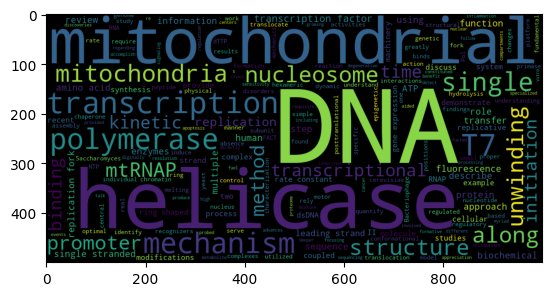

In [107]:
all_keywords = []
for i, entry in abstracts.iterrows():
    all_keywords += entry['Keywords'] 

keyword_string = (' ').join(all_keywords)
wordcloud = WordCloud(width = 1000, height = 500).generate(keyword_string)
plt.imshow(wordcloud)